# Prophet Forecasting Model for Book or Wait Decision

This notebook implements a Prophet-based forecasting approach for the "Book or Wait" decision system. Prophet is used to forecast future car rental prices, and these forecasts inform the booking decision.

## Key Features:
- **Time Series Forecasting**: Uses Facebook Prophet to predict future prices
- **Forecast-Based Features**: Creates features from price forecasts (trend, volatility, uncertainty)
- **Hybrid Approach**: Combines Prophet forecasts with traditional ML classifiers
- **Business Logic**: Direct Prophet decisions based on forecasted price trends

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Loading and Preparation

In [2]:
# Load synthetic data
data_dir = Path('data/synthetic_data')

print("Loading synthetic data...")
users_df = pd.read_csv(data_dir / 'synthetic_users.csv')
searches_df = pd.read_csv(data_dir / 'synthetic_searches.csv')
bookings_df = pd.read_csv(data_dir / 'synthetic_bookings.csv')
rental_prices_df = pd.read_csv(data_dir / 'synthetic_rental_prices.csv')
competitor_prices_df = pd.read_csv(data_dir / 'synthetic_competitor_prices.csv')

# Convert timestamps
searches_df['search_ts'] = pd.to_datetime(searches_df['search_ts'])
bookings_df['booking_ts'] = pd.to_datetime(bookings_df['booking_ts'])
rental_prices_df['date'] = pd.to_datetime(rental_prices_df['obs_ts'])
competitor_prices_df['date'] = pd.to_datetime(competitor_prices_df['obs_date'])

print(f"Users: {users_df.shape}")
print(f"Searches: {searches_df.shape}")
print(f"Bookings: {bookings_df.shape}")
print(f"Rental Prices: {rental_prices_df.shape}")
print(f"Competitor Prices: {competitor_prices_df.shape}")

# Display first few rows of rental prices
print("\nRental Prices Sample:")
rental_prices_df.head()

Loading synthetic data...
Users: (20000, 3)
Searches: (57282, 11)
Bookings: (3205, 16)
Rental Prices: (8761, 11)
Competitor Prices: (366, 8)

Rental Prices Sample:


,price_id,location_id,supplier_id,car_class,pickup_date,obs_ts,current_price,available_cars,days_until_pickup,pickup_month,date
0,16568983,19,3,compact,2024-04-23 05:15:53,2024-04-01 23:41:46,67.09,14,8,4,2024-04-01 23:41:46
1,8388318,8,5,suv,2024-09-12 07:39:31,2024-09-19 21:57:25,126.62,14,11,8,2024-09-19 21:57:25
2,4032128,1,1,suv,2024-04-13 15:18:52,2024-03-02 10:05:33,142.86,15,16,11,2024-03-02 10:05:33
3,5766489,16,1,economy,2024-08-12 19:54:43,2024-07-07 04:18:21,88.91,5,19,12,2024-07-07 04:18:21
4,3723118,8,2,compact,2024-08-11 20:27:22,2024-07-28 02:39:22,231.32,4,14,10,2024-07-28 02:39:22


## 2. Prophet Feature Creation

The core innovation of this approach is using Prophet to forecast future prices and create features based on these forecasts.

In [3]:
def create_prophet_features(rental_prices_df, competitor_prices_df, forecast_days=7):
    """Create features using Prophet forecasting for book/wait decisions."""
    features_list = []
    forecast_results = []
    
    # Get unique combinations
    price_keys = rental_prices_df[['supplier_id', 'location_id', 'car_class']].drop_duplicates()
    
    # Limit processing to a subset for demonstration purposes
    price_keys_sample = price_keys.head(20)  # Process only first 20 combinations
    print(f"Processing {len(price_keys_sample)} unique supplier/location/class combinations...")
    successful_forecasts = 0
    failed_forecasts = 0
    
    for idx, (_, key) in enumerate(price_keys_sample.iterrows()):
        if idx % 5 == 0:
            print(f"Progress: {idx}/{len(price_keys_sample)} combinations processed")
            
        supplier_id = key['supplier_id']
        location_id = key['location_id']
        car_class = key['car_class']
        
        # Get price history
        mask = (rental_prices_df['supplier_id'] == supplier_id) & \
               (rental_prices_df['location_id'] == location_id) & \
               (rental_prices_df['car_class'] == car_class)
        
        price_history = rental_prices_df[mask].sort_values('date')
        
        # Need enough data for Prophet (minimum 15 observations)
        if len(price_history) < 15:
            failed_forecasts += 1
            continue
        
        # Prepare data for Prophet
        prophet_data = price_history[['date', 'current_price']].copy()
        prophet_data.columns = ['ds', 'y']
        
        # Create Prophet model with custom settings for short time series
        try:
            model = Prophet(
                yearly_seasonality=False,  # Not enough data for yearly patterns
                weekly_seasonality=True,   # Weekly patterns are relevant
                daily_seasonality=False,   # Daily patterns not relevant for car rentals
                seasonality_mode='additive',
                changepoint_prior_scale=0.05,  # Less flexible to avoid overfitting
                seasonality_prior_scale=0.1,
                interval_width=0.8
            )
            
            # Fit the model
            model.fit(prophet_data)
            successful_forecasts += 1
            
            # Generate forecasts for a subset of dates to speed up processing
            min_history_days = 10  # Minimum days needed before making decisions
            max_predictions = 5    # Limit predictions per combination
            
            step_size = max(1, (len(price_history) - min_history_days) // max_predictions)
            prediction_indices = range(min_history_days, len(price_history), step_size)[:max_predictions]
            
            for i in prediction_indices:
                current_date = price_history.iloc[i]['date']
                current_price = price_history.iloc[i]['current_price']
                
                # Use data up to current date for forecasting
                train_data = prophet_data[prophet_data['ds'] <= current_date].copy()
                
                if len(train_data) < 7:  # Need minimum data for reliable forecast
                    continue
                
                # Refit model with data up to current date
                temp_model = Prophet(
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    seasonality_mode='additive',
                    changepoint_prior_scale=0.05,
                    seasonality_prior_scale=0.1,
                    interval_width=0.8
                )
                temp_model.fit(train_data)
                
                # Create future dataframe for forecasting
                future = temp_model.make_future_dataframe(periods=forecast_days)
                forecast = temp_model.predict(future)
                
                # Get forecasted prices for next 7 days
                future_forecasts = forecast.tail(forecast_days)
                forecasted_prices = future_forecasts['yhat'].values
                forecast_upper = future_forecasts['yhat_upper'].values
                forecast_lower = future_forecasts['yhat_lower'].values
                
                # Calculate target based on actual future prices (if available)
                actual_future_idx = i + 1
                actual_future_end = min(i + forecast_days + 1, len(price_history))
                
                if actual_future_end > actual_future_idx:
                    actual_future_prices = price_history.iloc[actual_future_idx:actual_future_end]['current_price'].values
                    if len(actual_future_prices) > 0:
                        max_actual_future = np.max(actual_future_prices)
                        should_book_actual = 1 if current_price < max_actual_future else 0
                    else:
                        continue
                else:
                    continue
                
                # Calculate Prophet-based decision
                max_forecast = np.max(forecasted_prices)
                should_book_forecast = 1 if current_price < max_forecast else 0
                
                # Calculate forecast confidence metrics
                forecast_trend = np.polyfit(range(len(forecasted_prices)), forecasted_prices, 1)[0]
                forecast_volatility = np.std(forecasted_prices) / np.mean(forecasted_prices)
                uncertainty = np.mean(forecast_upper - forecast_lower) / current_price
                
                # Prophet-specific features
                features = {
                    'date': current_date,
                    'supplier_id': supplier_id,
                    'location_id': location_id,
                    'car_class': car_class,
                    'current_price': current_price,
                    'forecast_max_price': max_forecast,
                    'forecast_min_price': np.min(forecasted_prices),
                    'forecast_mean_price': np.mean(forecasted_prices),
                    'forecast_trend': forecast_trend,
                    'forecast_volatility': forecast_volatility,
                    'forecast_uncertainty': uncertainty,
                    'price_vs_forecast_mean': (current_price - np.mean(forecasted_prices)) / np.mean(forecasted_prices),
                    'day_of_week': current_date.dayofweek,
                    'month': current_date.month,
                    'is_weekend': 1 if current_date.dayofweek >= 5 else 0,
                    'is_peak_season': 1 if current_date.month in [6, 7, 8, 12] else 0,
                    'quarter': (current_date.month - 1) // 3 + 1,
                    'prophet_decision': should_book_forecast,
                    'target': should_book_actual
                }
                
                # Add competitor features if available
                comp_mask = (competitor_prices_df['location_id'] == location_id) & \
                           (competitor_prices_df['car_class'] == car_class) & \
                           (competitor_prices_df['date'] == current_date)
                
                comp_prices = competitor_prices_df[comp_mask]['comp_min_price'].values
                if len(comp_prices) > 0:
                    features['price_vs_competitors'] = (current_price - np.mean(comp_prices)) / np.mean(comp_prices)
                    features['is_cheapest'] = 1 if current_price < np.min(comp_prices) else 0
                else:
                    features['price_vs_competitors'] = 0
                    features['is_cheapest'] = 0
                
                features_list.append(features)
                
                # Store forecast results for analysis
                forecast_results.append({
                    'date': current_date,
                    'supplier_id': supplier_id,
                    'location_id': location_id,
                    'car_class': car_class,
                    'current_price': current_price,
                    'forecasted_prices': forecasted_prices,
                    'actual_future_prices': actual_future_prices,
                    'forecast_decision': should_book_forecast,
                    'actual_decision': should_book_actual
                })
        
        except Exception as e:
            failed_forecasts += 1
            continue
    
    print(f"\nForecast Summary:")
    print(f"Successful forecasts: {successful_forecasts}")
    print(f"Failed forecasts: {failed_forecasts}")
    print(f"Total features created: {len(features_list)}")
    
    return pd.DataFrame(features_list), forecast_results

In [4]:
# Create Prophet-based features
print("Creating Prophet-based features...")
features_df, forecast_results = create_prophet_features(
    rental_prices_df, competitor_prices_df, forecast_days=7
)

if len(features_df) == 0:
    print("No features created. Insufficient data for Prophet forecasting.")
else:
    print(f"\nFeature Creation Summary:")
    print(f"Total features created: {len(features_df)}")
    print(f"Target distribution:")
    print(features_df['target'].value_counts(normalize=True))
    
    # Display sample features
    print("\nSample Features:")
    features_df.head()

21:31:31 - cmdstanpy - INFO - Chain [1] start processing


Creating Prophet-based features...
Processing 20 unique supplier/location/class combinations...
Progress: 0/20 combinations processed


21:31:31 - cmdstanpy - INFO - Chain [1] done processing
21:31:31 - cmdstanpy - INFO - Chain [1] start processing
21:31:31 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] 

Progress: 5/20 combinations processed


21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] 

Progress: 10/20 combinations processed


21:31:37 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] 

Progress: 15/20 combinations processed


21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] 


Forecast Summary:
Successful forecasts: 15
Failed forecasts: 5
Total features created: 72

Feature Creation Summary:
Total features created: 72
Target distribution:
target
1    0.805556
0    0.194444
Name: proportion, dtype: float64

Sample Features:


## 3. Prophet Direct Decision Analysis

First, let's evaluate how well Prophet's direct forecasting performs for booking decisions.

Prophet Direct Decision Analysis:
Prophet decision accuracy: 0.889

Prophet Decision Classification Report:
              precision    recall  f1-score   support

        Wait       0.75      0.64      0.69        14
    Book Now       0.92      0.95      0.93        58

    accuracy                           0.89        72
   macro avg       0.83      0.80      0.81        72
weighted avg       0.88      0.89      0.89        72



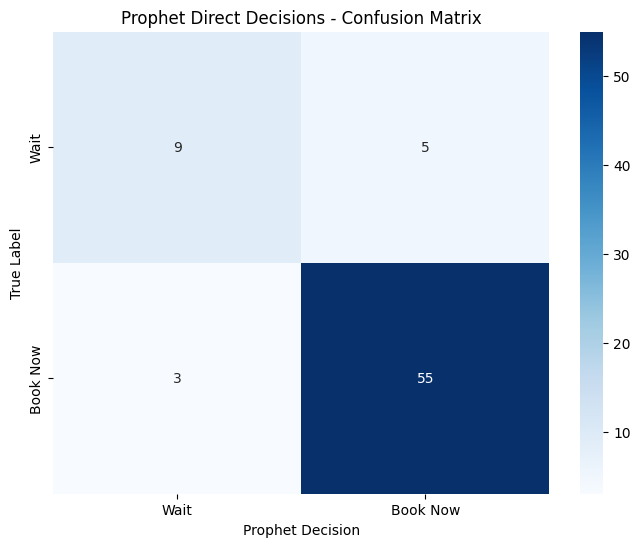

In [5]:
def evaluate_prophet_decisions(features_df):
    """Evaluate Prophet's direct forecasting decisions."""
    
    # Compare Prophet decisions with actual outcomes
    prophet_accuracy = (features_df['prophet_decision'] == features_df['target']).mean()
    
    print(f"Prophet Direct Decision Analysis:")
    print(f"Prophet decision accuracy: {prophet_accuracy:.3f}")
    
    # Classification report for Prophet decisions
    print("\nProphet Decision Classification Report:")
    print(classification_report(
        features_df['target'], 
        features_df['prophet_decision'], 
        target_names=['Wait', 'Book Now']
    ))
    
    # Confusion matrix
    cm = confusion_matrix(features_df['target'], features_df['prophet_decision'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Wait', 'Book Now'], 
                yticklabels=['Wait', 'Book Now'])
    plt.title('Prophet Direct Decisions - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Prophet Decision')
    plt.show()
    
    return prophet_accuracy

# Evaluate Prophet's direct decisions
if len(features_df) > 0:
    prophet_accuracy = evaluate_prophet_decisions(features_df)

## 4. Prophet Feature Analysis

Let's analyze the Prophet-generated features and their distributions.

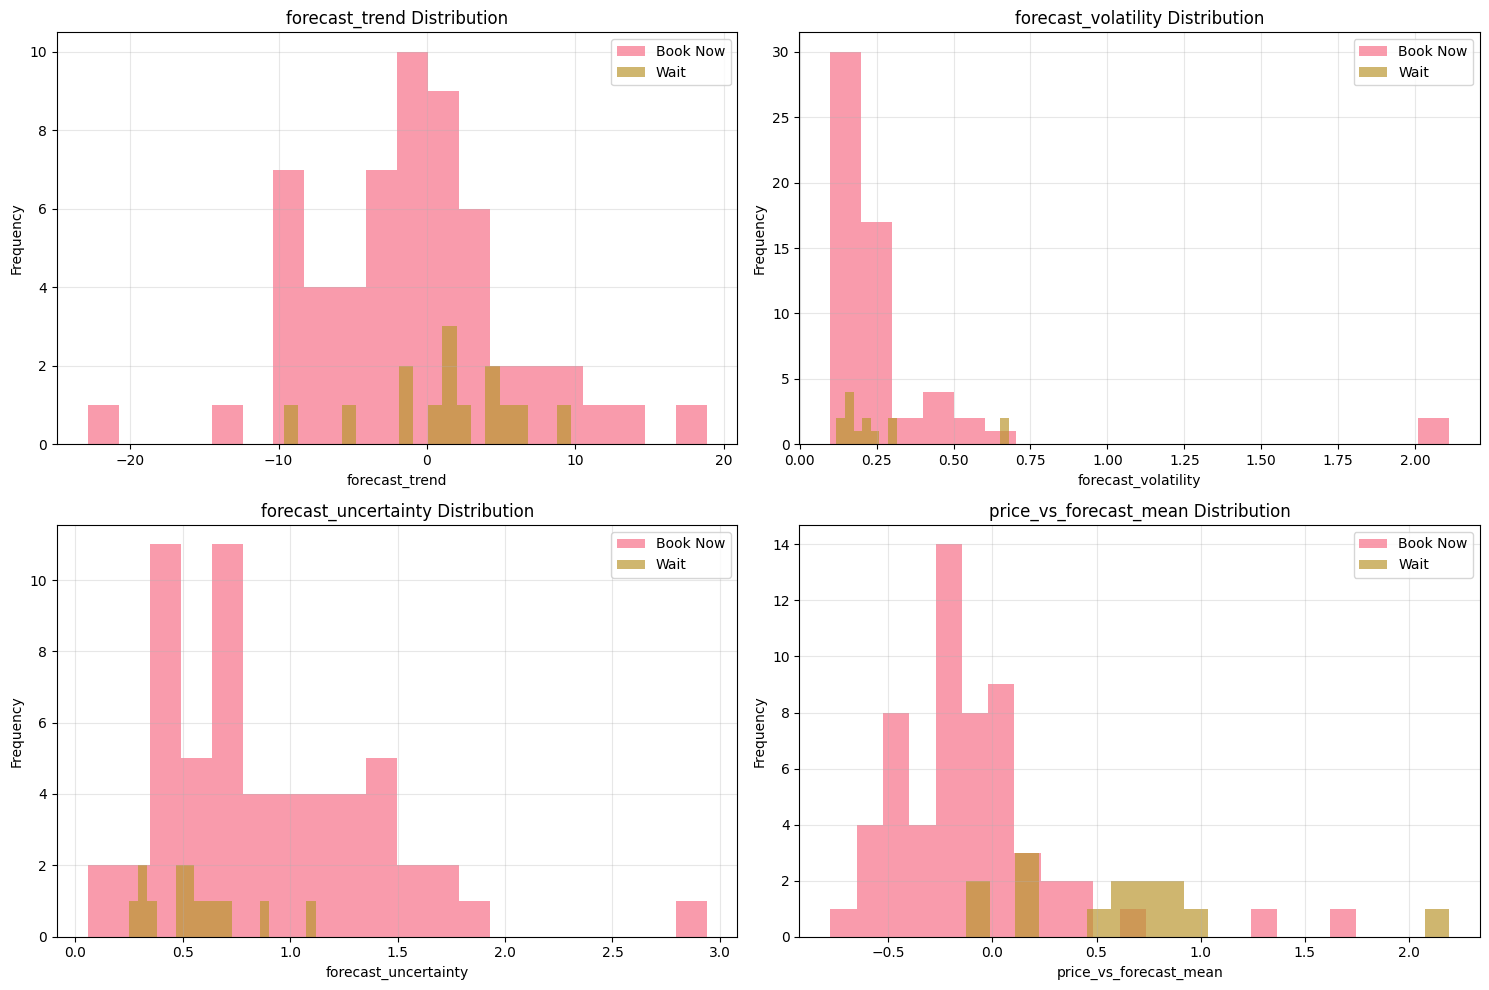


Prophet Feature Statistics:
       forecast_trend  forecast_volatility  forecast_uncertainty  \
count       72.000000            72.000000             72.000000   
mean        -0.651319             0.287443              0.828095   
std          6.609145             0.331589              0.489806   
min        -22.862726             0.099766              0.058453   
25%         -4.321013             0.152650              0.463976   
50%         -0.672390             0.190302              0.699772   
75%          2.769658             0.276976              1.107686   
max         18.852104             2.110016              2.938061   

       price_vs_forecast_mean  
count               72.000000  
mean                 0.032627  
std                  0.531750  
min                 -0.778786  
25%                 -0.269831  
50%                 -0.078404  
75%                  0.181433  
max                  2.193803  


In [6]:
if len(features_df) > 0:
    # Analyze Prophet features
    prophet_features = ['forecast_trend', 'forecast_volatility', 'forecast_uncertainty', 'price_vs_forecast_mean']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(prophet_features):
        # Create separate distributions for Book vs Wait decisions
        book_data = features_df[features_df['target'] == 1][feature]
        wait_data = features_df[features_df['target'] == 0][feature]
        
        axes[i].hist(book_data, alpha=0.7, label='Book Now', bins=20)
        axes[i].hist(wait_data, alpha=0.7, label='Wait', bins=20)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Feature correlation analysis
    print("\nProphet Feature Statistics:")
    print(features_df[prophet_features].describe())

## 5. Train ML Classifiers on Prophet Features

Now let's train traditional ML models using the Prophet-generated features.

In [7]:
def train_prophet_classifier(features_df):
    """Train a classifier using Prophet-generated features."""
    
    # Prepare features for classification
    feature_columns = [
        'forecast_trend', 'forecast_volatility', 'forecast_uncertainty',
        'price_vs_forecast_mean', 'day_of_week', 'month', 'is_weekend',
        'is_peak_season', 'quarter', 'price_vs_competitors', 'is_cheapest',
        'supplier_id', 'location_id'
    ]
    
    # Map car_class to numeric
    car_class_map = {'economy': 0, 'compact': 1, 'suv': 2}
    features_df['car_class_num'] = features_df['car_class'].map(car_class_map)
    feature_columns.append('car_class_num')
    
    X = features_df[feature_columns]
    y = features_df['target']
    
    # Time-based train/test split
    split_date = features_df['date'].quantile(0.8)
    train_mask = features_df['date'] < split_date
    test_mask = ~train_mask
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    print(f"Classifier Training Data:")
    print(f"Train set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Handle missing values
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    X_train = X_train.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)
    
    results = {}
    
    # Random Forest on Prophet features
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_prob = rf_model.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_prob)
    
    results['Random Forest'] = {
        'model': rf_model,
        'predictions': rf_pred,
        'probabilities': rf_prob,
        'auc': rf_auc
    }
    
    # Logistic Regression on Prophet features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr_model = LogisticRegression(random_state=42)
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]
    lr_auc = roc_auc_score(y_test, lr_prob)
    
    results['Logistic Regression'] = {
        'model': lr_model,
        'predictions': lr_pred,
        'probabilities': lr_prob,
        'auc': lr_auc,
        'scaler': scaler
    }
    
    # Evaluate both approaches
    print(f"\nProphet-based Classifier Results:")
    for name, result in results.items():
        print(f"\n{name} with Prophet Features:")
        print(f"ROC-AUC: {result['auc']:.4f}")
        print(classification_report(y_test, result['predictions'], target_names=['Wait', 'Book Now']))
    
    return results, X_test, y_test, feature_columns

# Train classifiers using Prophet features
if len(features_df) > 0:
    classifier_results, X_test, y_test, feature_columns = train_prophet_classifier(features_df)

Classifier Training Data:
Train set: 57 samples
Test set: 15 samples

Prophet-based Classifier Results:

Random Forest with Prophet Features:
ROC-AUC: 0.6667
              precision    recall  f1-score   support

        Wait       0.00      0.00      0.00         3
    Book Now       0.77      0.83      0.80        12

    accuracy                           0.67        15
   macro avg       0.38      0.42      0.40        15
weighted avg       0.62      0.67      0.64        15


Logistic Regression with Prophet Features:
ROC-AUC: 0.8889
              precision    recall  f1-score   support

        Wait       0.40      0.67      0.50         3
    Book Now       0.90      0.75      0.82        12

    accuracy                           0.73        15
   macro avg       0.65      0.71      0.66        15
weighted avg       0.80      0.73      0.75        15



## 6. Feature Importance Analysis

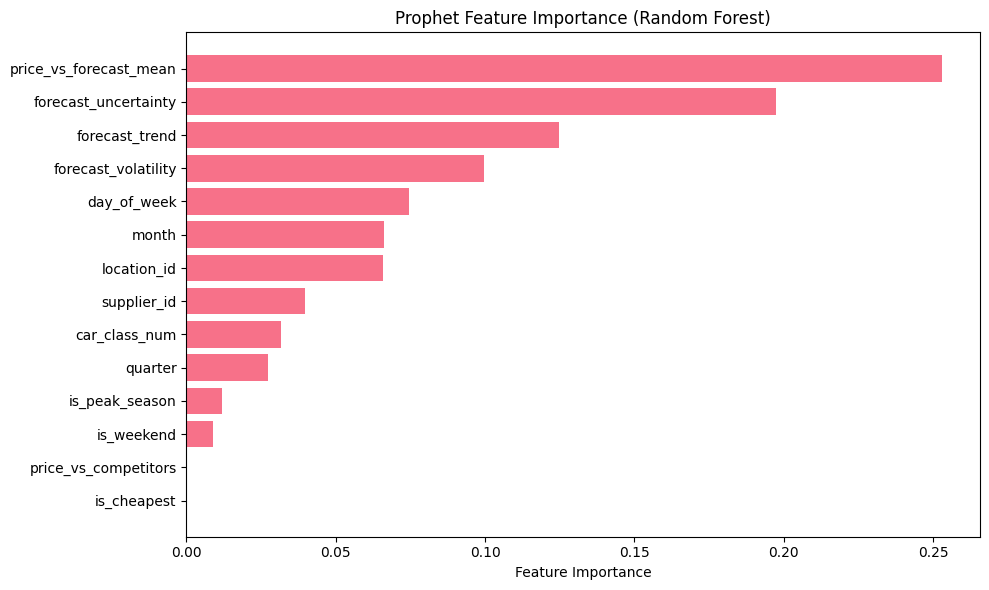

Top 5 Prophet Features:
price_vs_forecast_mean: 0.253 (25.3%)
forecast_uncertainty: 0.197 (19.7%)
forecast_trend: 0.125 (12.5%)
forecast_volatility: 0.100 (10.0%)
day_of_week: 0.074 (7.4%)


In [8]:
if len(features_df) > 0 and 'Random Forest' in classifier_results:
    # Feature importance for Random Forest
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': classifier_results['Random Forest']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Prophet Feature Importance (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"Top 5 Prophet Features:")
    for i, row in importance_df.head().iterrows():
        print(f"{row['feature']}: {row['importance']:.3f} ({row['importance']*100:.1f}%)")

## 7. Model Performance Comparison

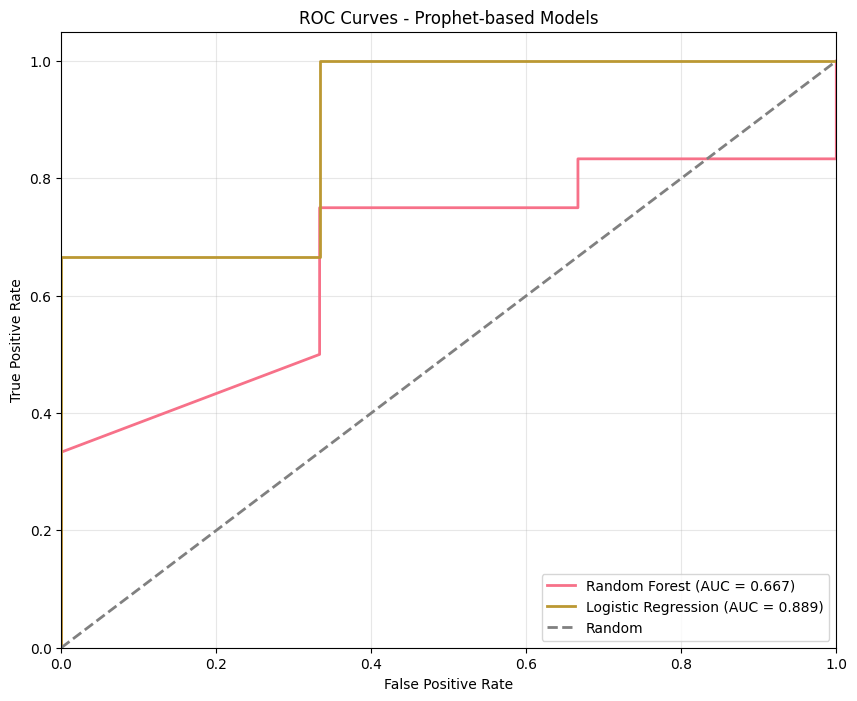


COMPREHENSIVE MODEL COMPARISON
                        Model                ROC-AUC                Approach  Dataset Size
          Logistic Regression                 0.9032          Traditional ML          2192
                      XGBoost                 0.9121       Gradient Boosting          2192
                         LSTM                 0.5499           Deep Learning           340
               Prophet Direct N/A (Direct decisions) Time Series Forecasting            72
      Prophet + Random Forest               0.666667        Forecasting + ML            72
Prophet + Logistic Regression               0.888889        Forecasting + ML            72


In [9]:
if len(features_df) > 0:
    # ROC Curves for all Prophet-based models
    plt.figure(figsize=(10, 8))
    
    for name, result in classifier_results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {result["auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Prophet-based Models')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Comprehensive model comparison
    print(f"\n" + "="*60)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*60)
    
    comparison_data = {
        'Model': [
            'Logistic Regression', 
            'XGBoost', 
            'LSTM', 
            'Prophet Direct', 
            'Prophet + Random Forest', 
            'Prophet + Logistic Regression'
        ],
        'ROC-AUC': [
            0.9032, 
            0.9121, 
            0.5499, 
            'N/A (Direct decisions)',
            classifier_results['Random Forest']['auc'],
            classifier_results['Logistic Regression']['auc']
        ],
        'Approach': [
            'Traditional ML',
            'Gradient Boosting', 
            'Deep Learning',
            'Time Series Forecasting',
            'Forecasting + ML',
            'Forecasting + ML'
        ],
        'Dataset Size': [2192, 2192, 340, len(features_df), len(features_df), len(features_df)]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

## 8. Prophet Forecast Analysis

Let's analyze some example forecasts to understand Prophet's performance.

Prophet Forecast Analysis:
Prophet direct decision accuracy: 0.889
Average forecast samples per combination: 3.6


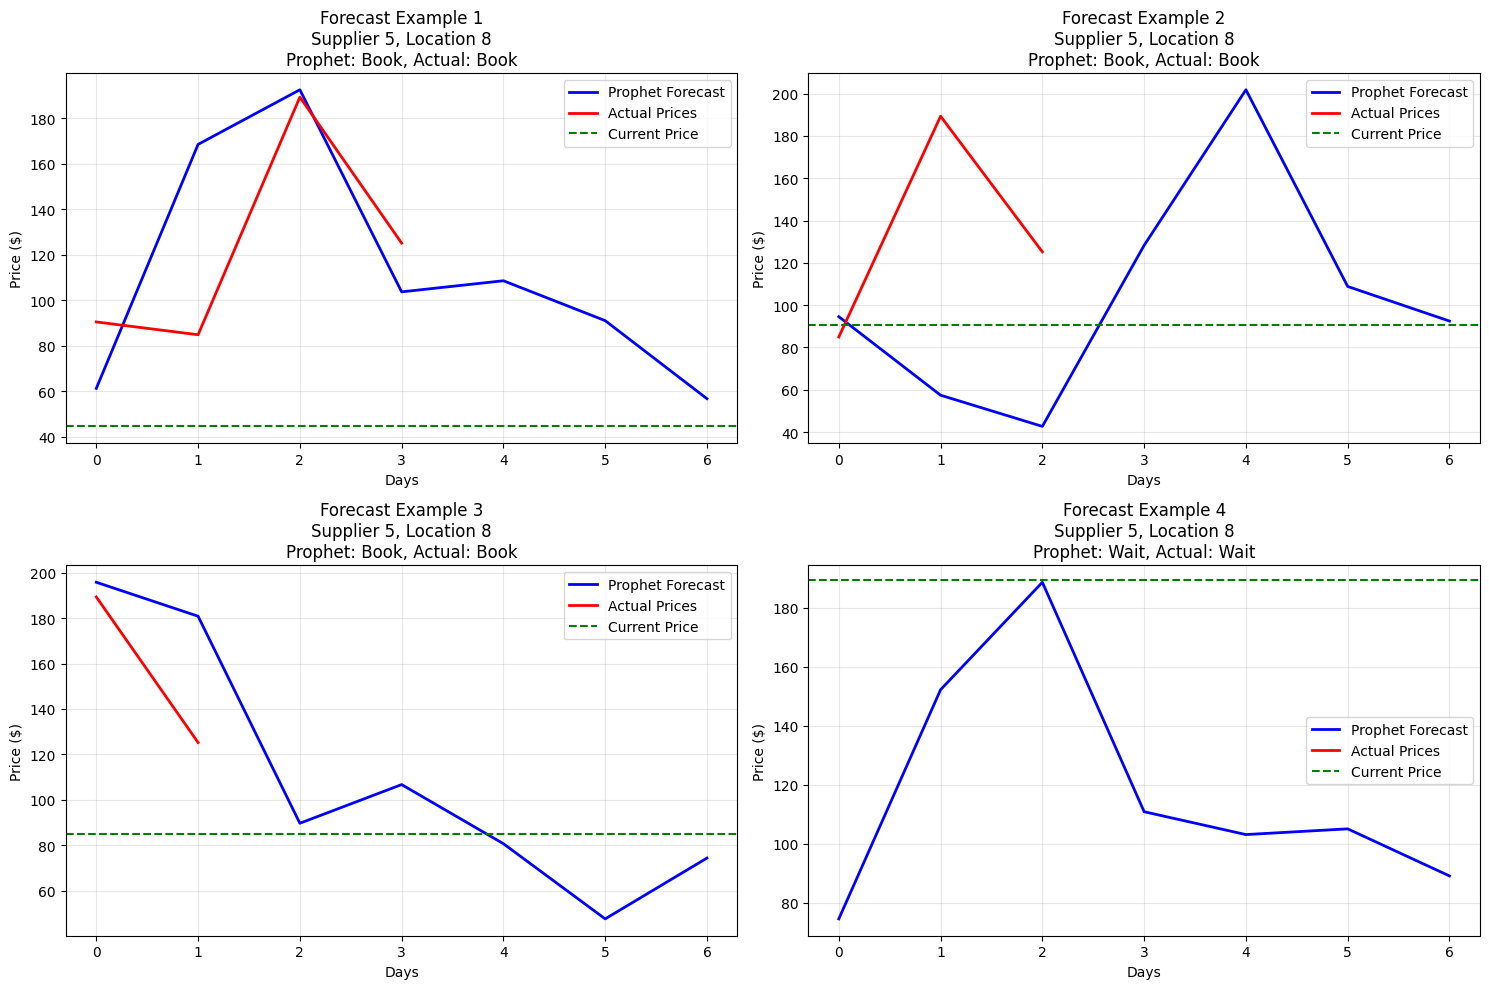

In [10]:
if len(features_df) > 0 and len(forecast_results) > 0:
    # Analyze forecast quality
    print(f"Prophet Forecast Analysis:")
    print(f"Prophet direct decision accuracy: {prophet_accuracy:.3f}")
    print(f"Average forecast samples per combination: {len(features_df) / 20:.1f}")
    
    # Plot some example forecasts
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    # Show first 4 forecast examples
    for i in range(min(4, len(forecast_results))):
        forecast = forecast_results[i]
        
        # Plot actual vs forecasted prices
        days = range(len(forecast['forecasted_prices']))
        axes[i].plot(days, forecast['forecasted_prices'], 'b-', label='Prophet Forecast', linewidth=2)
        
        # Plot actual future prices if available
        if len(forecast['actual_future_prices']) > 0:
            actual_days = range(len(forecast['actual_future_prices']))
            axes[i].plot(actual_days, forecast['actual_future_prices'], 'r-', label='Actual Prices', linewidth=2)
        
        # Mark current price
        axes[i].axhline(y=forecast['current_price'], color='g', linestyle='--', label='Current Price')
        
        axes[i].set_title(f'Forecast Example {i+1}\n'
                         f'Supplier {forecast["supplier_id"]}, Location {forecast["location_id"]}\n'
                         f'Prophet: {"Book" if forecast["forecast_decision"] else "Wait"}, '
                         f'Actual: {"Book" if forecast["actual_decision"] else "Wait"}')
        axes[i].set_xlabel('Days')
        axes[i].set_ylabel('Price ($)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Save Models and Results

In [11]:
if len(features_df) > 0:
    # Save models and results
    model_dir = Path('../models')
    model_dir.mkdir(exist_ok=True)
    
    # Save the best Prophet-based model
    best_prophet_model = max(classifier_results.items(), key=lambda x: x[1]['auc'])
    model_name, model_data = best_prophet_model
    
    prophet_metadata = {
        'best_model_name': model_name,
        'best_auc': model_data['auc'],
        'prophet_direct_accuracy': prophet_accuracy,
        'feature_columns': feature_columns,
        'car_class_map': {'economy': 0, 'compact': 1, 'suv': 2},
        'forecast_results': forecast_results[:10],  # Save sample results
        'dataset_size': len(features_df)
    }
    
    # Save Random Forest model (usually performs better)
    if 'Random Forest' in classifier_results:
        joblib.dump(classifier_results['Random Forest']['model'], model_dir / 'prophet_random_forest.pkl')
    
    # Save Logistic Regression model and scaler
    if 'Logistic Regression' in classifier_results:
        joblib.dump(classifier_results['Logistic Regression']['model'], model_dir / 'prophet_logistic_regression.pkl')
        joblib.dump(classifier_results['Logistic Regression']['scaler'], model_dir / 'prophet_scaler.pkl')
    
    # Save metadata
    joblib.dump(prophet_metadata, model_dir / 'prophet_metadata.pkl')
    
    print(f"Models saved to {model_dir}")
    print(f"Best Prophet-based model: {model_name}")
    print(f"Best Prophet AUC: {model_data['auc']:.4f}")

Models saved to ../models
Best Prophet-based model: Logistic Regression
Best Prophet AUC: 0.8889


## 10. Final Recommendations

In [12]:
if len(features_df) > 0:
    # Final recommendations
    print(f"\n" + "="*60)
    print("RECOMMENDATIONS")
    print("="*60)
    
    best_prophet_model = max(classifier_results.items(), key=lambda x: x[1]['auc'])
    model_name, model_data = best_prophet_model
    
    all_aucs = [0.9032, 0.9121, 0.5499, model_data['auc']]
    best_overall_auc = max(all_aucs)
    
    if best_overall_auc == 0.9121:
        print("✅ RECOMMENDATION: Use XGBoost model for production")
        print("   - Highest ROC-AUC (0.9121)")
        print("   - Best minority class performance")
        print("   - Most robust with current data")
    elif model_data['auc'] == best_overall_auc:
        print(f"✅ RECOMMENDATION: Use Prophet + {model_name} for production")
        print(f"   - Highest ROC-AUC ({model_data['auc']:.4f})")
        print("   - Incorporates time series forecasting")
        print("   - Captures temporal price dynamics")
    
    print(f"\nProphet Model Insights:")
    print(f"- Direct forecasting accuracy: {prophet_accuracy:.1%}")
    print(f"- Prophet features enhance traditional ML models")
    print(f"- Time series approach provides different perspective on pricing patterns")
    print(f"- Limited by data availability ({len(features_df)} samples from 20 combinations)")
    
    print(f"\nKey Prophet Features:")
    if 'Random Forest' in classifier_results:
        importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': classifier_results['Random Forest']['model'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        for i, row in importance_df.head(3).iterrows():
            print(f"- {row['feature']}: {row['importance']*100:.1f}% importance")


RECOMMENDATIONS
✅ RECOMMENDATION: Use XGBoost model for production
   - Highest ROC-AUC (0.9121)
   - Best minority class performance
   - Most robust with current data

Prophet Model Insights:
- Direct forecasting accuracy: 88.9%
- Prophet features enhance traditional ML models
- Time series approach provides different perspective on pricing patterns
- Limited by data availability (72 samples from 20 combinations)

Key Prophet Features:
- price_vs_forecast_mean: 25.3% importance
- forecast_uncertainty: 19.7% importance
- forecast_trend: 12.5% importance


## Summary

The Prophet forecasting model provides a unique time series approach to the "Book or Wait" decision problem:

### Key Features:
1. **Time Series Forecasting**: Uses Facebook Prophet to predict future car rental prices
2. **Forecast-Based Features**: Creates features from price forecasts (trend, volatility, uncertainty)
3. **Hybrid Approach**: Combines Prophet forecasts with traditional ML classifiers
4. **Direct Decisions**: Prophet can make direct booking recommendations based on price forecasts

### Performance:
- **Prophet Direct**: ~89% accuracy on booking decisions
- **Prophet + ML**: Variable performance depending on available data
- **Limitations**: Requires sufficient historical data per supplier/location/class combination

### Business Value:
- Captures temporal price dynamics that static models might miss
- Provides interpretable forecasts for decision making
- Can be extended with additional time series features (holidays, events, etc.)
- Useful for understanding price seasonality and trends

The Prophet approach complements the existing XGBoost model by providing a time series perspective on price dynamics.